In [ ]:
using DMRJtensor
include("su2_tools.jl")


In [2]:
# setup system, only isotropic J for now
spinmag = 1.0;
Sx,Sy,Sz,Sp,Sm,O,Id = spinOps(spinmag)
Ns = 40 # number of sites
J_arr = [1.0, 2.0]; # J_p array, e.g. H = sum_p[ -J_p (S*S)^p ]
H_onesite = H_SU2(spinmag, J_arr) # make the onsite term
H_mpo = makeMPO(H_onesite,size(Id,1),Ns); # make the MPO!
psi0 = makePsi0(spinmag,Ns);
psi = copy(psi0)
println(psi[1])

printing regular tensor of type: tens{Complex{Float64}}
size = (1, 3, 1)
T = Complex{Float64}[0.8655840898269316 + 0.4209896172363887im, 0.7954602607105958 + 0.06498938863738091im, 0.26049778202242146 + 0.5688201879895844im]



In [6]:
# DMRG sweeps, with refinement 

nsweeps_m10 = 20
nsweeps_m40 = 10
nsweeps_m80 = 5

for i in 1:nsweeps_m10
    @time dmrg(psi, H_mpo, maxm = 10, cutoff = 1E-4)
end
println("coarse run completed")
for i in 1:nsweeps_m40
    @time dmrg(psi, H_mpo, maxm = 40, cutoff = 1E-8)
end
println("intermediate run completed")
#for i in 1:nsweeps_m80
#    @time dmrg(psi, H_mpo, maxm = 80, cutoff = 1E-15)
#end
#println("fine run completed")
variance = expect(psi,H_mpo,H_mpo)- (expect(psi, H_mpo))^2
println("variance is, ",variance)

 10.239422 seconds (25.31 M allocations: 1.984 GiB, 5.27% gc time)
  0.248440 seconds (166.02 k allocations: 240.144 MiB, 6.17% gc time)
  0.288929 seconds (166.02 k allocations: 240.144 MiB, 3.81% gc time)
  0.272498 seconds (166.02 k allocations: 240.144 MiB, 4.10% gc time)
  0.290517 seconds (165.78 k allocations: 239.511 MiB, 5.17% gc time)
  0.285933 seconds (165.78 k allocations: 239.511 MiB, 4.03% gc time)
  0.289392 seconds (165.78 k allocations: 239.511 MiB, 4.08% gc time)
  0.284842 seconds (165.78 k allocations: 239.511 MiB, 4.21% gc time)
  0.278440 seconds (165.78 k allocations: 239.511 MiB, 4.23% gc time)
  0.288950 seconds (165.78 k allocations: 239.511 MiB, 4.32% gc time)
  0.276463 seconds (165.78 k allocations: 239.511 MiB, 5.79% gc time)
  0.297642 seconds (165.78 k allocations: 239.511 MiB, 4.09% gc time)
  0.508178 seconds (165.78 k allocations: 239.511 MiB, 46.17% gc time)
  0.430497 seconds (165.78 k allocations: 239.511 MiB, 35.71% gc time)
  0.290875 seconds (1

In [7]:
# Evaluate energy and average net magnetization

H_tot = expect(psi,H_mpo)

Sz_onesite = [Id O
              Sz Id];
Sz_mpo = makeMPO(Sz_onesite,size(Id,1),Ns); # make the MPO!
Sx_onesite = [Id O
              Sx Id];
Sx_mpo = makeMPO(Sx_onesite,size(Id,1),Ns); # make the MPO!
Sy_onesite = [Id O
              Sy Id];
Sy_mpo = makeMPO(Sy_onesite,size(Id,1),Ns); # make the MPO!

Sx_tot = expect(psi,Sx_mpo)
Sy_tot = expect(psi,Sy_mpo)
Sz_tot = expect(psi,Sz_mpo)

println("H_tot: ", real(H_tot))
println("Avg|M|: ",norm([Sx_tot,Sy_tot,Sz_tot])/Ns)

H_tot: -180.42724752303457
Avg|M|: 2.3179460367410043e-7


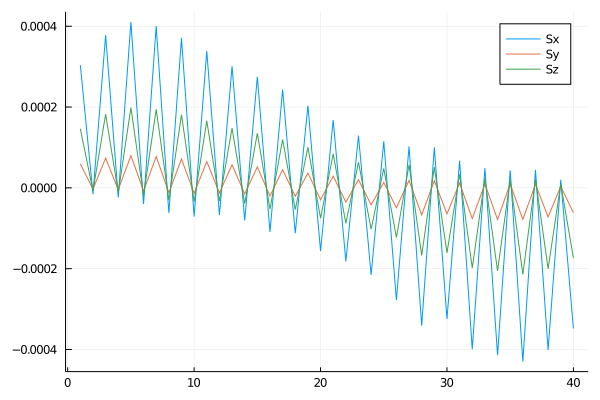

In [8]:
# Evaluate and plot the site-dependent magnetization
S_vals = zeros(ComplexF64,Ns,3)
S_ops = [Sx, Sy, Sz]

S0 = [Id O 
      O Id]
S0_mpo = Array{Array{ComplexF64,2},1}(undef,Ns)

for site = 1:Ns
   S0_mpo[site] = S0
end

for site = 1:Ns
    for op_idx = 1:3
        Sop_here = copy(S0_mpo)
        Sop_here[site] = [Id            O
                          S_ops[op_idx] Id]
        mpo_h = makeMPO(Sop_here,size(Id,1),Ns)
        S_vals[site,op_idx] = expect(psi,mpo_h)
    end
end

using Plots
plot(broadcast(real,S_vals[:,1]),label="Sx")
plot!(broadcast(real,S_vals[:,2]),label="Sy")
plot!(broadcast(real,S_vals[:,3]),label="Sz")